In [4]:
import sklearn
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
import re
from sklearn.metrics import classification_report


data = pd.read_csv("/content/weather_data.csv", delimiter = ';')

core_data = data[["time","month", "temperature", "feelslike", "precipitation"]].copy()
core_data.columns = ["time", "month", "temp", "flike", "precip"]

core_data["target"] = core_data.shift(-1)["temp"]
core_data = core_data.iloc[:-1,:].copy()

reg = Ridge(alpha=.1)

predictors = ["precip", "temp", "flike"]

train = core_data[:4000]

test = core_data[4000:]

reg.fit(train[predictors], train["target"])
predictions = reg.predict(test[predictors])

from sklearn.metrics import mean_absolute_error

mean_absolute_error(test["target"], predictions)



1.6990496288404024

In [5]:
combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
combined.columns = ["actual", "predictions"]

#precip âm và thấp do khả năng mưa của sài gòn là ít,
# flike cao nhất có nghĩa rằng thông số feellike ảnh hưởng lớn nhất đến dự đoán
# thật ra cũng không cao lắm so với nhiệt độ thực tế

reg.coef_


array([-0.51471989,  0.25192002,  0.38467497])

In [6]:
def create_predictions(predictors, core_data, reg):
    train = core_data.loc[4000:6000]
    test = core_data.loc[6000:]
    reg.fit(train[predictors], train["target"])
    predictions = reg.predict(test[predictors])
    error = mean_absolute_error(test["target"], predictions)
    combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
    combined.columns = ["actual", "predictions"]
    return error, combined


In [7]:

#lấy nhiệt độ trung bình 1 tháng trở lại đặt vào cột month_max
core_data["month_avg"] = core_data["temp"].rolling(30).mean()

#tỉ lệ nhiệt độ hôm nay / 1 tháng qua
core_data["temp_ratio_monthAvg"] = core_data["temp"] / core_data["month_avg"]

#tỉ lệ nhiệt độ thực / nhiệt độ cảm thấy
core_data["real/feel"] = core_data["temp"] / core_data["flike"]

predictors = ["precip", "temp", "flike", "month_avg", "temp_ratio_monthAvg", "real/feel"]

core_data = core_data.iloc[30:,:].copy()

error, combined = create_predictions(predictors, core_data, reg)

error

1.6610128333795287

In [8]:
reg.coef_

array([-0.2885536 ,  0.62156389,  0.04431034,  0.01240347, -0.43997132,
       -6.80746694])

In [ ]:
core_data.head()

,time,month,temp,flike,precip,target,month_avg,temp_ratio_monthAvg,real/feel
30,18:00,1,26.0,30.0,0.0,25.0,26.633333,0.976220,0.866667
31,21:00,1,25.0,28.0,0.4,24.0,26.700000,0.936330,0.892857
32,0:00,1,24.0,27.0,0.0,24.0,26.733333,0.897756,0.888889
33,3:00,1,24.0,27.0,0.0,24.0,26.600000,0.902256,0.888889
34,6:00,1,24.0,27.0,0.0,28.0,26.366667,0.910240,0.888889


In [10]:
core_data.corr()["target"]

<ipython-input-10-d2dbf3bfab0c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  core_data.corr()["target"]


month                 -0.189328
temp                   0.736504
flike                  0.694773
precip                -0.113039
target                 1.000000
month_avg              0.396756
temp_ratio_monthAvg    0.597505
real/feel             -0.017284
Name: target, dtype: float64

In [54]:
combined["diff"] = (combined["actual"] - combined["predictions"]).abs()
combined.sort_values("diff", ascending=False).head()
combined


,actual,predictions,diff
6000,26.0,27.550014,1.550014
6001,26.0,26.277498,0.277498
6002,29.0,25.993165,3.006835
6003,34.0,28.174074,5.825926
6004,35.0,31.142905,3.857095
...,...,...,...
8506,29.0,26.227070,2.772930
8507,33.0,28.370882,4.629118
8508,34.0,31.118442,2.881558
8509,31.0,31.757591,0.757591


<Axes: >

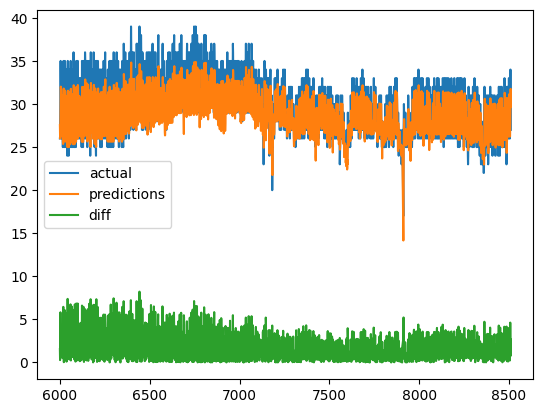

In [55]:
combined.plot()

In [56]:
from sklearn.metrics import r2_score
score = r2_score(combined["actual"], combined["predictions"])
score

0.5353290446757472